In [1]:
import pandas as pd
import json
import requests
import folium
import matplotlib.pyplot as plt

In [2]:
incidentsdf = pd.read_csv('incidents_may.csv', usecols=["id", "priority", "implicated", "incident_time", "latitude", "longitude"])

#drop duplicates
incidentsdf = incidentsdf.drop_duplicates(subset="id", keep="first")

#cast incident_time to datetime
incidentsdf["incident_time"] = pd.to_datetime(incidentsdf["incident_time"])

#fill nan to 0 and cast implicated to int
incidentsdf["implicated"] = incidentsdf["implicated"].fillna(0)
incidentsdf["implicated"] = incidentsdf["implicated"].astype(int)

#calculate intervals and create column
new = incidentsdf.groupby(pd.Grouper(key="incident_time", freq='1H')).apply(lambda x: x['incident_time'])
incidentsdf["interval"] = new.index.get_level_values(0)

#multiindex by interval, then id
incidentsdf = incidentsdf.set_index(["interval", "id"])

#print head
incidentsdf.head()

priority  latitude  longitude  implicated  \
interval            id                                                 
2022-04-30 23:00:00 57518         2  4.705279 -74.127686           2   
                    57519         1  4.600571 -74.143379           3   
2022-05-01 00:00:00 57520         1  4.647777 -74.137123           1   
                    57521         1  4.720405 -74.075302           2   
                    57522         1  4.614258 -74.167252           2   

                                incident_time  
interval            id                         
2022-04-30 23:00:00 57518 2022-04-30 23:59:00  
                    57519 2022-04-30 23:54:00  
2022-05-01 00:00:00 57520 2022-05-01 00:08:00  
                    57521 2022-05-01 00:10:00  
                    57522 2022-05-01 00:11:00

In [3]:
incidentsdf.groupby(["interval"]).count()

,priority,latitude,longitude,implicated,incident_time
interval,,,,,
2022-04-30 23:00:00,2,2,2,2,2
2022-05-01 00:00:00,7,7,7,7,7
2022-05-01 01:00:00,15,15,15,15,15
2022-05-01 02:00:00,6,6,6,6,6
2022-05-01 03:00:00,7,7,7,7,7
...,...,...,...,...,...
2022-05-25 19:00:00,33,33,33,33,33
2022-05-25 20:00:00,19,19,19,19,19
2022-05-25 21:00:00,14,14,14,14,14


In [4]:
#set matplotlib global size to 20x10
plt.rcParams['figure.figsize'] = (20, 10)

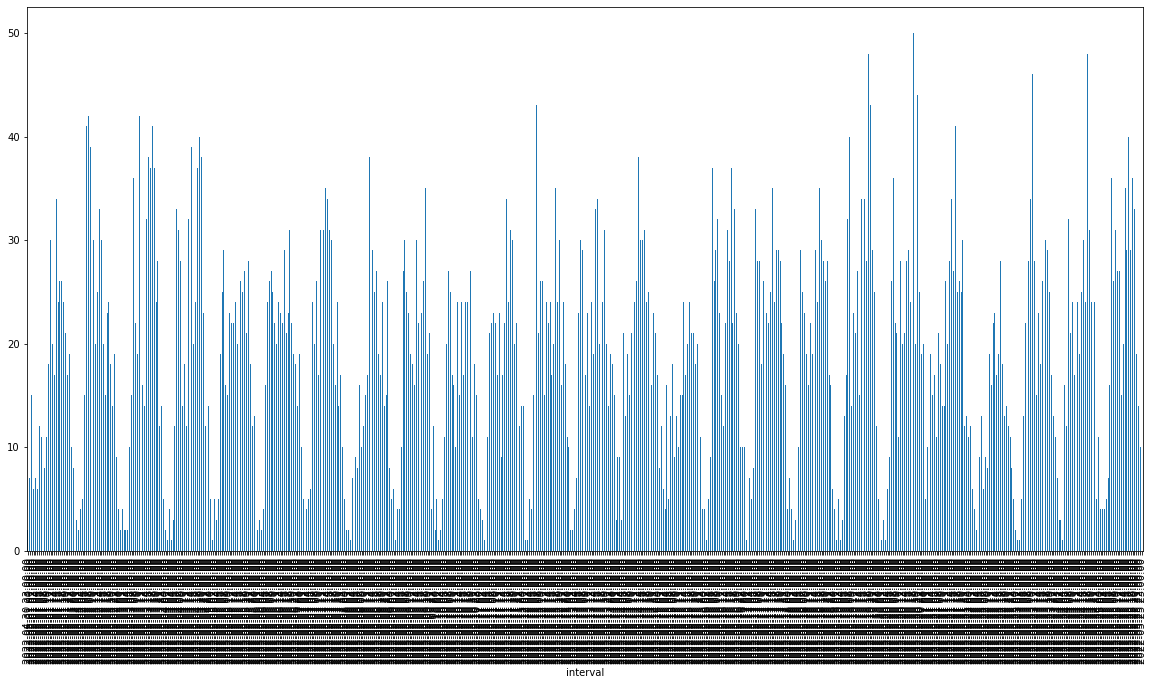

In [5]:
#barplot of incidents per interval
incidentsdf.groupby(["interval"]).count()["priority"].plot(kind="bar")
plt.show()

In [6]:
agentsdf = pd.read_csv('agents_may.csv', usecols=["dev_id", "time_stamp", "latitude", "longitude"])

#cast time_stamp to datetime
agentsdf["time_stamp"] = pd.to_datetime(agentsdf["time_stamp"])

#calculate intervals and create column
new = agentsdf.groupby(pd.Grouper(key="time_stamp", freq='1H')).apply(lambda x: x['time_stamp'])
agentsdf["interval"] = new.index.get_level_values(0)

#multiindex by interval, then id
agentsdf = agentsdf.set_index(["interval", "dev_id"]).reset_index().drop_duplicates(subset=["interval", "dev_id"], keep="last").set_index(["interval", "dev_id"])

#print head
agentsdf.head()

time_stamp  latitude  longitude
interval   dev_id                                                  
2022-05-01 868033050102534 2022-05-01 00:01:42  4.650030 -74.147322
           868033050090085 2022-05-01 00:01:47  4.581688 -74.128348
           868033050103508 2022-05-01 00:01:52  4.551098 -74.147635
           868033050101650 2022-05-01 00:01:55  4.619840 -74.159668
           868033050102989 2022-05-01 00:01:56  4.651116 -74.136658

In [7]:
incidents_locations = incidentsdf[["longitude","latitude"]].apply(lambda x: ','.join(x.values.astype(str)), axis=1)
incidents_locations.head()

interval             id   
2022-04-30 23:00:00  57518       -74.127685546875,4.705278873443604
                     57519    -74.14337921142578,4.6005706787109375
2022-05-01 00:00:00  57520    -74.13712310791016,4.6477766036987305
                     57521     -74.07530212402344,4.720405101776123
                     57522     -74.16725158691406,4.614258289337158
dtype: object

In [8]:
agents_locations = agentsdf[["longitude","latitude"]].apply(lambda x: ','.join(x.values.astype(str)), axis=1)
agents_locations

interval             dev_id         
2022-05-01 00:00:00  868033050102534    -74.1473218,4.6500299
                     868033050090085    -74.1283484,4.5816876
                     868033050103508    -74.1476347,4.5510981
                     868033050101650      -74.1596683,4.61984
                     868033050102989    -74.1366581,4.6511155
                                                ...          
2022-05-30 23:00:00  868033050100140    -74.1179133,4.5588983
                     868033050099250    -74.1772431,4.6360906
                     868033050099821    -74.0850125,4.5963301
                     868033050090317      -74.15399,4.6363333
                     868033050101932     -74.1399241,4.617186
Length: 86101, dtype: object

In [9]:
incidents_sample = incidents_locations.sample(1000, random_state=0)
agents_sample = agents_locations.sample(1000, random_state=0)

In [10]:
incidents_sample = incidents_locations.xs("2022-05-01 01:00:00")
agents_sample = agents_locations.xs("2022-05-01 01:00:00")

In [11]:
folium_map = folium.Map(
    location=[4.6534649, -74.0836453], zoom_start=12, tiles="CartoDB positron"
)

incidents_feature_group = folium.FeatureGroup(name="Incidents")
for i in range(len(incidents_sample)):
    marker = folium.CircleMarker(
        location=incidents_sample.iloc[i].split(",")[::-1],
        radius=1,
        color="red",
        fill=True,
        fill_opacity=0.3,
    )
    marker.add_to(incidents_feature_group)

agents_feature_group = folium.FeatureGroup(name="Agents")
for i in range(len(agents_sample)):
    marker = folium.CircleMarker(
        location=agents_sample.iloc[i].split(",")[::-1],
        radius=1,
        color="blue",
        fill=True,
        fill_opacity=0.3,
    )
    marker.add_to(agents_feature_group)

incidents_feature_group.add_to(folium_map)
agents_feature_group.add_to(folium_map)

folium.LayerControl().add_to(folium_map)
folium_map


In [12]:
agents_coordinates = ";".join(agents_sample)
incidents_coordinates = ";".join(incidents_sample)
coordinates = agents_coordinates + ";" + incidents_coordinates

agents_count = agents_sample.shape[0]
sources = ";".join(str(i) for i in range(agents_count))

incidents_count = incidents_sample.shape[0]
destinations = ";".join(
    str(i) for i in range(agents_count, agents_count + incidents_count)
)

#Ojo con correr esto sin estar corriendo el servicio.
durations = json.loads(
    requests.get(
        f"http://127.0.0.1:5000/table/v1/driving/{coordinates}?sources={sources}&destinations={destinations}"
    ).text
)["durations"]


ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /table/v1/driving/-74.0995867,4.615981;-74.1241795,4.6196585;-74.1059283,4.6298267;-74.1366581,4.6511155;-74.1561167,4.5804683;-74.1352133,4.58698;-74.1092917,4.5796633;-74.106445,4.5866167;-74.1161715,4.6694361;-74.116225,4.61031;-74.1547399,4.5883178;-74.140527,4.5983103;-74.1100911,4.5868611;-74.1172057,4.6157602;-74.1354525,4.5763805;-74.1131562,4.6522242;-74.0812621,4.6000139;-74.1045128,4.6822799;-74.108515,4.5516463;-74.1377591,4.5891261;-74.1681975,4.5808575;-74.1028983,4.6184283;-74.11724,4.7138533;-74.1380083,4.5862667;-74.1337581,4.7024305;-74.1167681,4.6204234;-74.1519302,4.6502737;-74.1210833,4.6001233;-74.1353083,4.63264;-74.1217769,4.5574569;-74.0546768,4.6713906;-74.1334068,4.5840831;-74.1970551,4.6411838;-74.1080293,4.6077622;-74.0812033,4.5798129;-74.133665,4.586195;-74.106885,4.615795;-74.0997067,4.6157967;-74.1473483,4.6500037;-74.1945733,4.6230483;-74.1075067,4.6056567;-74.1029428,4.5760111;-74.1254,4.7589017;-74.1868048,4.6165278;-74.1142467,4.704675;-74.1023717,4.618825;-74.0471331,4.6624718;-74.08969,4.59334;-74.0979346,4.6164329;-74.0470406,4.6622886;-74.1515253,4.6808654;-74.0987004,4.5589141;-74.080455,4.59633;-74.1083027,4.6089342;-74.1081137,4.5650883;-74.1015664,4.5654479;-74.10643,4.619235;-74.1687766,4.6931036;-74.0490769,4.7395747;-74.1284672,4.5817106;-74.2009945,4.5800895;-74.1880321,4.5986754;-74.11123657226562,4.681146621704102;-74.11922454833984,4.668676376342773;-74.18736267089844,4.621780872344971;-74.17829132080078,4.597104549407959;-74.07024383544922,4.604316234588623;-74.1416015625,4.550992965698242;-74.14993286132812,4.56264591217041;-74.15193176269531,4.578229427337647;-74.16399383544922,4.5955491065979;-74.10365295410156,4.546347141265869;-74.05162811279297,4.722286224365234;-74.04696655273438,4.664573669433594;-74.1770248413086,4.625897407531738;-74.0972900390625,4.555251598358154;-74.11215209960938,4.619846820831299?sources=0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61&destinations=62;63;64;65;66;67;68;69;70;71;72;73;74;75;76 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f37ede1d2a0>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
#Finally, we can create a dataframe with the durations in seconds.}

df = pd.DataFrame(durations)
#df = df.apply(lambda x: x/60)

#df = df.set_index(agents_sample.index.get_level_values(1))
#df = df.set_axis(list(incidents_sample.index.get_level_values(1)), axis=1)

df


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,894.1,821.6,890.0,671.8,490.9,1038.8,984.2,826.3,816.8,841.8,1281.6,1126.9,945.4,743.5,267.0
1,707.8,635.3,682.6,490.1,634.7,892.2,807.9,644.6,635.1,1094.3,1103.5,1027.4,638.9,996.0,346.7
2,741.3,668.8,836.3,757.1,535.9,1159.2,1074.9,911.6,902.1,1130.8,1137.0,1060.9,792.6,1032.5,418.2
3,575.9,510.5,770.9,824.9,850.9,1227.0,1142.7,979.4,969.9,1365.9,1344.3,1268.2,727.2,1267.6,653.3
4,1185.0,1112.5,509.3,291.1,1065.0,405.3,321.0,89.6,316.7,762.0,1580.7,1504.6,569.2,850.8,756.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,961.2,879.2,1297.1,1356.1,1382.1,1758.2,1673.9,1510.6,1501.1,1897.1,1759.1,1729.7,1253.4,1798.8,1184.5
58,920.7,1122.2,1509.2,1369.8,937.2,1771.9,1687.6,1524.3,1514.8,1684.3,157.8,661.6,1465.5,1586.0,1219.9
59,1106.2,1033.7,646.4,428.2,855.9,499.8,445.2,490.8,573.2,635.8,1501.9,1425.8,716.5,724.6,569.3
60,1305.4,1232.9,469.6,334.9,1185.4,790.5,706.2,542.9,312.3,1147.2,1701.1,1625.0,539.7,1236.0,877.0


In [ ]:
df.to_csv("durations.csv", index=False)

---

In [ ]:
incidents_locations

interval             id   
2022-04-30 23:00:00  57518       -74.127685546875,4.705278873443604
                     57519    -74.14337921142578,4.6005706787109375
2022-05-01 00:00:00  57520    -74.13712310791016,4.6477766036987305
                     57521     -74.07530212402344,4.720405101776123
                     57522     -74.16725158691406,4.614258289337158
                                              ...                  
2022-05-25 23:00:00  68383      -74.0933609008789,4.744298934936523
                     68384        -74.0780258178711,4.6522536277771
                     68385     -74.12010192871094,4.678952693939209
                     68386     -74.03235626220703,4.703181266784668
                     68387     -74.08690643310547,4.753690242767334
Length: 10870, dtype: object

In [ ]:
    marker = folium.CircleMarker(
        location=incidents_sample.iloc[i].split(",")[::-1],
        radius=1,
        color="red",
        fill=True,
        fill_opacity=0.3,
    )

IndexError: single positional indexer is out-of-bounds

In [ ]:
df = pd.read_csv(
    "incidents_may.csv",
    usecols=["id", "priority", "implicated", "incident_time", "latitude", "longitude"],
)

# drop duplicates
df = df.drop_duplicates(subset="id", keep="first")

# cast incident_time to datetime
df["incident_time"] = pd.to_datetime(df["incident_time"])

# fill nan to 0 and cast implicated to int
df["implicated"] = df["implicated"].fillna(0)
df["implicated"] = df["implicated"].astype(int)

# calculate intervals and create column
new = df.groupby(pd.Grouper(key="incident_time", freq="1D")).apply(
    lambda x: x["incident_time"]
)
df["interval"] = new.index.get_level_values(0)

# multiindex by interval, then id
df = df.set_index(["interval", "id"])

# print head
df.head()


In [ ]:
df.index.get_level_values(0).unique()

In [ ]:
df[(df.index.get_level_values(0) == '2022-04-30')]

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly as py

# min day in your dataset
day = 1998

# your color-scale
scl = [[0.0, '#ffffff'],[0.2, '#b4a8ce'],[0.4, '#8573a9'],
       [0.6, '#7159a3'],[0.8, '#5732a1'],[1.0, '#2c0579']] # purples

data_slider = []
for day in df.index.get_level_values(0).unique():
    df_segmented =  df[(df.index.get_level_values(0) == day)]

    for col in df_segmented.columns:
        df_segmented[col] = df_segmented[col].astype(str)

    data_each_yr = dict(
                        type='choropleth',
                        locations = df_segmented['state'],
                        z=df_segmented['sightings'].astype(float),
                        locationmode='USA-states',
                        colorscale = scl,
                        colorbar= {'title':'# Sightings'})

    data_slider.append(data_each_yr)

steps = []
for i in range(len(data_slider)):
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label='Day {}'.format(i + 1998))
    step['args'][1][i] = True
    steps.append(step)

sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

layout = dict(title ='UFO Sightings by State Since 1998', geo=dict(scope='usa',
                       projection={'type': 'albers usa'}),
              sliders=sliders)

fig = dict(data=data_slider, layout=layout)
periscope.plotly(fig)

In [ ]:
# Selecting the day to display
day = '2022-05-01'
tmp = df.xs(day)

incidents_sample.iloc[i].split(",")[::-1]

# Create the figure and feed it all the prepared columns
fig = go.Figure(
    go.Scattermapbox(
        lat=tmp['lat'],
        lon=tmp['lon'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=tmp['size'],
            color=tmp['color']
        )
    )
)

# Specify layout information
fig.update_layout(
    mapbox=dict(
        center=go.layout.mapbox.Center(lat=45, lon=-73),
        zoom=1
    )
)

# Display the figure
fig.show()